## Загрузим данные

In [1]:
%pip install gdown

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [3]:
RANDOM_STATE=42

In [4]:
CARS_FILE_ID = '1liFEe1-yFISPSpRSvbv1wIH_avYNGmBI'

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

!gdown --id {CARS_FILE_ID}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1liFEe1-yFISPSpRSvbv1wIH_avYNGmBI
From (redirected): https://drive.google.com/uc?id=1liFEe1-yFISPSpRSvbv1wIH_avYNGmBI&confirm=t&uuid=6420014c-6e4e-4124-a06f-00091587da17
To: /content/dataset.csv
100% 1.01G/1.01G [00:11<00:00, 91.4MB/s]


In [5]:
import pandas as pd

df = pd.read_csv('dataset.csv', low_memory=False)
print(df.shape)

(604047, 24)


In [6]:
df_with_na_column = df[df['engine_displacement'].isna()]
df_with_na_column

,production_year,mileage,condition,owners_number,pts_original,horse_power,accidents_resolution,region,seller_type,brand,...,engine_displacement,engine_power,fuel_rate,steering_wheel,price,price_segment,tags,auto_class,equipment,complectation_available_options
210905,2003,175000,CONDITION_OK,0,True,NaN,NaN,Чебаркуль,PRIVATE,Hyundai,...,NaN,NaN,NaN,LEFT,380000,MEDIUM,available_for_checkup;pts_original;real_photo;...,NaN,seats-5,NaN


In [7]:
df.drop(210905, inplace=True)

In [8]:
df['fuel_rate'].fillna(df['fuel_rate'].median(), inplace=True)

<ipython-input-8-3003548066>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['fuel_rate'].fillna(df['fuel_rate'].median(), inplace=True)


In [9]:
df['pts_original'].fillna(True, inplace=True)
df['accidents_resolution'].fillna('OK', inplace=True)
df['auto_class'].fillna('NOT SPECIFIED', inplace=True)

<ipython-input-9-2371127630>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pts_original'].fillna(True, inplace=True)
<ipython-input-9-2371127630>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['pts_original'].fillna(True, inplace=True)
<ipython-input-9-2371127630>:2: FutureWarning: A value is trying

In [10]:
df.drop('horse_power', axis=1, inplace=True)

In [11]:
def get_unique_values(series, sep=';'):
    uniq = set()
    for cell in series.dropna():
        for piece in cell.split(sep):
            s = piece.strip()
            if s:
                uniq.add(s)
    return np.array(list(uniq))

all_tags = get_unique_values(df['tags'])
all_options = get_unique_values(df['complectation_available_options'])
all_equipments = get_unique_values(df['equipment'])

In [12]:
def create_binary_features(df, column, unique_values, sep=';'):
    return (
        df[column]
        .str.get_dummies(sep=sep)
        .reindex(columns=unique_values, fill_value=0)
        .astype('int8')
    )

tags_dummies = create_binary_features(df, 'tags', all_tags)
options_dummies = create_binary_features(df, 'complectation_available_options', all_options)
equipment_dummies = create_binary_features(df, 'equipment', all_equipments)

In [13]:
tags_dummies = tags_dummies.astype('Sparse[int]')
options_dummies = options_dummies.astype('Sparse[int]')
equipment_dummies = equipment_dummies.astype('Sparse[int]')

In [14]:
full_df = pd.concat([
    df.drop(columns=['tags', 'complectation_available_options', 'equipment']),
    tags_dummies,
    options_dummies.drop(columns=['condition']),
    equipment_dummies.drop(columns=['condition'])
], axis=1)

In [15]:
duplicated_cols = full_df.columns[full_df.columns.duplicated()].unique()
for col in duplicated_cols:
    full_df[col] = full_df[col].astype("int8")

In [16]:
import numpy as np

names = full_df.columns[full_df.columns.duplicated()].unique()
new_cols = {}

for name in names:
    cols_i = [col for col in full_df.columns if col == name]
    sub_df = full_df.loc[:, cols_i].astype('int8')   # DataFrame shape (n_rows, k)

    # берём максимум по строкам → Series shape (n_rows,)
    max_series = sub_df.max(axis=1).astype('int8')

    new_cols[name] = max_series

    # удаляем *все* старые колонки с этим именем
    full_df.drop(columns=cols_i, inplace=True)

# теперь присваиваем новые колонки–Series (они одномерны!)
for name, s in new_cols.items():
    full_df[name] = s


<ipython-input-16-845014932>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_df[name] = s
<ipython-input-16-845014932>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_df[name] = s
<ipython-input-16-845014932>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_df[name] = s
<ipython-i

In [17]:
full_df.sample(10)

,production_year,mileage,condition,owners_number,accidents_resolution,region,seller_type,brand,model,body_type,...,immo,xenon,18-inch-wheels,folding-front-passenger-seat,activ-suspension,front-camera,night-vision,airbag-driver,remote-engine-start,volume-sensor
436947,2024,0,CONDITION_OK,0,OK,Санкт-Петербург,COMMERCIAL,Skoda,Karoq,ALLROAD_5_DOORS,...,1,0,1,0,0,0,0,1,0,0
329729,2020,40460,CONDITION_OK,1,ERROR,Москва,PRIVATE,Mercedes-Benz,E-Класс,COUPE_HARDTOP,...,1,0,1,0,0,0,0,1,0,1
343497,2000,380000,CONDITION_OK,4,OK,Москва,PRIVATE,Mercedes-Benz,M-Класс,ALLROAD_5_DOORS,...,0,0,0,0,0,0,0,0,0,0
439784,2019,170000,CONDITION_OK,1,ERROR,Москва,PRIVATE,Skoda,Octavia,LIFTBACK,...,1,0,0,0,0,0,0,0,0,1
550845,2023,107,CONDITION_OK,1,OK,Краснодар,PRIVATE,Lada (ВАЗ),Largus,WAGON_5_DOORS,...,1,0,0,0,0,0,0,1,0,0
431808,2015,110727,CONDITION_OK,1,OK,Уфа,COMMERCIAL,Renault,Sandero,HATCHBACK_5_DOORS,...,1,0,0,0,0,0,0,1,0,0
167063,2024,0,CONDITION_OK,0,OK,Химки,COMMERCIAL,Genesis,GV80 Coupe,ALLROAD_5_DOORS,...,1,0,0,0,1,0,0,1,0,0
391523,2022,13000,CONDITION_OK,0,OK,Владивосток,COMMERCIAL,Nissan,X-Trail,ALLROAD_5_DOORS,...,0,0,0,0,0,0,0,0,0,0
210052,2024,100,CONDITION_OK,1,OK,Новосибирск,PRIVATE,Hyundai,Elantra,SEDAN,...,0,0,0,0,0,0,0,0,0,0
46816,2024,34,CONDITION_OK,1,OK,Москва,COMMERCIAL,BMW,X5,ALLROAD_5_DOORS,...,0,0,0,0,0,0,0,0,0,0


In [18]:
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

numeric_df = full_df.select_dtypes(include=[np.number])
numeric_df = numeric_df.loc[:, numeric_df.nunique() > 1]

corr = numeric_df.corr().abs().fillna(0)

dist = 1 - corr

dist = (dist + dist.T) / 2
np.fill_diagonal(dist.values, 0)

dist = dist.clip(lower=0)

dist_vect = squareform(dist)
Z = hierarchy.linkage(dist_vect, method='average')

max_d = 0.4
clusters = hierarchy.fcluster(Z, t=max_d, criterion='distance')

cluster_df = pd.DataFrame({'feature': numeric_df.columns, 'cluster': clusters})
to_keep = ['production_year', 'mileage', 'owners_number', 'doors_count', 'seats', 'engine_displacement', 'engine_power', 'fuel_rate']
for c in cluster_df['cluster'].unique():
    members = cluster_df.loc[cluster_df['cluster'] == c, 'feature']
    avg_corr = corr.loc[members, members].mean().sort_values(ascending=False)
    to_keep.append(avg_corr.index[0])
to_keep = list(dict.fromkeys(to_keep))

to_drop = [col for col in numeric_df.columns if col not in to_keep]
df_reduced = full_df.drop(columns=to_drop)

print(f"Удалено числовых коррелирующих признаков: {len(to_drop)}")
print(f"Осталось признаков в df_reduced: {df_reduced.shape[1]} из {full_df.shape[1]}")

Удалено числовых коррелирующих признаков: 112
Осталось признаков в df_reduced: 304 из 416


In [19]:
df_reduced.sample(10)

,production_year,mileage,condition,owners_number,accidents_resolution,region,seller_type,brand,model,body_type,...,projection-display,laminated-safety-glass,third-rear-headrest,xenon,18-inch-wheels,folding-front-passenger-seat,activ-suspension,night-vision,remote-engine-start,volume-sensor
518746,2007,33000,CONDITION_OK,1,ERROR,Аксай,PRIVATE,Lada (ВАЗ),2107,SEDAN,...,0,0,0,0,0,0,0,0,0,0
224119,2021,23211,CONDITION_OK,1,OK,Москва,PRIVATE,Hyundai,Solaris,SEDAN,...,0,0,0,0,0,0,0,0,1,0
351020,2021,6122,CONDITION_OK,1,OK,Уссурийск,COMMERCIAL,Mini,Countryman,ALLROAD_5_DOORS,...,0,0,0,0,0,0,0,0,0,0
424138,2016,4500,CONDITION_OK,1,ERROR,Погар,PRIVATE,Renault,Kaptur,ALLROAD_5_DOORS,...,0,0,1,0,0,0,0,0,0,0
89776,2011,245600,CONDITION_OK,3,OK,Тверь,PRIVATE,Chevrolet,Aveo,SEDAN,...,0,0,0,0,0,0,0,0,0,0
297634,2023,18300,CONDITION_OK,1,OK,Москва,PRIVATE,Lexus,RX,ALLROAD_5_DOORS,...,0,0,1,0,0,0,0,0,0,0
449720,2024,0,CONDITION_OK,0,OK,Москва,COMMERCIAL,Soueast,S07,ALLROAD_5_DOORS,...,0,0,0,0,0,0,0,0,1,0
49847,2020,121000,CONDITION_OK,1,OK,Москва,PRIVATE,BMW,X6,ALLROAD_5_DOORS,...,1,0,1,0,0,1,0,0,1,1
48872,2024,0,CONDITION_OK,0,OK,Краснодар,COMMERCIAL,BMW,X6,ALLROAD_5_DOORS,...,0,0,0,0,0,0,0,0,0,0
846,1999,363500,CONDITION_OK,3,OK,Уфа,PRIVATE,Alfa Romeo,166,SEDAN,...,0,0,0,0,0,0,0,0,0,0


## Обучим LightGBM

In [20]:
!pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --install-option


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [22]:
X = df.drop('price', axis=1)
y = df['price']

In [23]:
num_features = X.select_dtypes(include=['int64', 'float64', 'int8']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

In [24]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features),
])

In [25]:
param = {
    'n_estimators': 1600,
    'learning_rate': 0.04230796771458062,
    'num_leaves': 109,
    'max_depth': 26,
    'subsample': 0.7744391789491678,
    'colsample_bytree': 0.5013855637546327,
    'reg_alpha': 0.08261606688965385,
    'reg_lambda': 0.2539614097187018,
    'min_child_weight': 18,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'random_seed':RANDOM_STATE,
    'verbose':-1
}

lgbm_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', LGBMRegressor(**param))
])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [27]:
lgbm_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['production_year', 'mileage',
                                                   'owners_number',
                                                   'doors_count',
                                                   'engine_displacement',
                                                   'engine_power',
                                                   'fuel_rate']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['condition',
                                                   'accidents_resolution',
                                                   'region', 'seller_type',
                                                   'brand', 'model',
                                                   'body_t...
                                                   'complectation_available_options'])])),
                ('model',
                 LGBMRegressor(colsample_bytree=0.5013855637546327,
                               device='gpu', gpu_device_id=0, gpu_platform_id=0,
                               learning_rate=0.04230796771458062, max_depth=26,
                               min_child_weight=18, n_estimators=1600,
                               num_leaves=109, random_seed=42,
                               reg_alpha=0.08261606688965385,
                               reg_lambda=0.2539614097187018,
                               subsample=0.7744391789491678, verbose=-1))])

In [28]:
y_pred_lgbm = lgbm_pipeline.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [29]:
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm  = r2_score(y_test, y_pred_lgbm)

In [30]:
print("LightGBM:")
print(f"  MSE:  {mse_lgbm:.2f}")
print(f"  MAE:  {mae_lgbm:.2f}")
print(f"  R^2:  {r2_lgbm:.2f}")

LightGBM:
  MSE:  7523005964093.32
  MAE:  469457.31
  R^2:  0.73


In [31]:
model = lgbm_pipeline.named_steps['model']
preproc = lgbm_pipeline.named_steps['preproc']
feature_names = preproc.get_feature_names_out()

importances = model.feature_importances_

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})
feat_imp = feat_imp.sort_values('importance', ascending=False).reset_index(drop=True)
top = feat_imp.head(20)
print(top)

                                 feature  importance
0                           num__mileage       19826
1                              cat__tags       17524
2                      num__engine_power       16172
3                         num__fuel_rate       14130
4                   num__production_year       13901
5               num__engine_displacement       13243
6                         cat__equipment       12333
7                             cat__model       12221
8                            cat__region       10203
9   cat__complectation_available_options        9438
10                            cat__brand        9315
11                            cat__seats        4918
12                    num__owners_number        4570
13                       cat__auto_class        4296
14                        cat__body_type        3916
15                    cat__price_segment        2064
16                      num__doors_count        1881
17                      cat__seller_type      

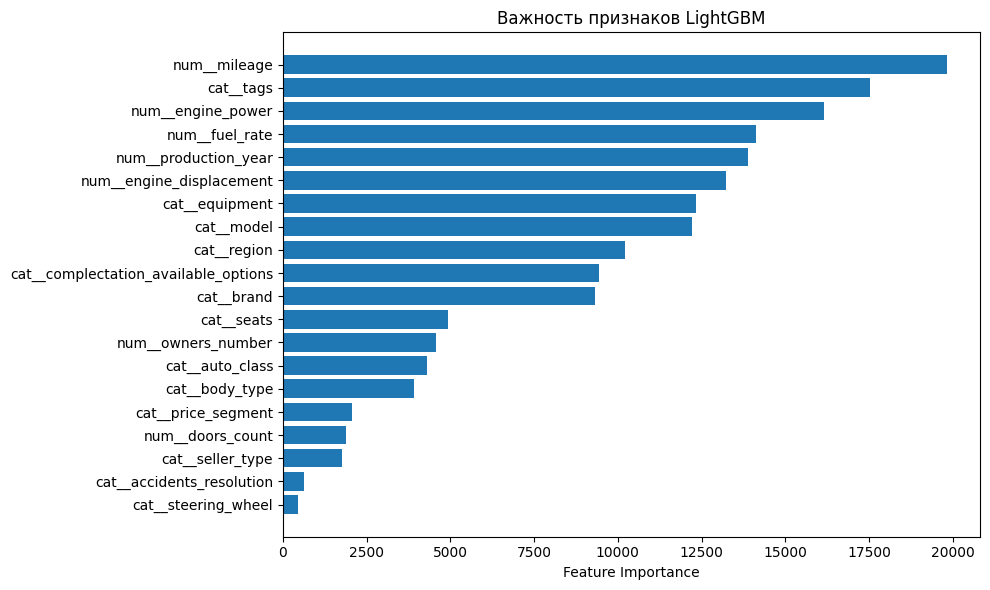

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top['feature'], top['importance'])
plt.xlabel('Feature Importance')
plt.title('Важность признаков LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Обучим Catboost

In [33]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.4 MB/s eta 0:00:00


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [36]:
X = df.drop('price', axis=1)
y = df['price']

In [37]:
num_features = X.select_dtypes(include=['int64', 'float64', 'int8']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

In [38]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features),
])

In [39]:
param = {
    'iterations': 599,
    'learning_rate': 0.05951760389847296,
    'depth': 10,
    'l2_leaf_reg': 2.04641012682822,
    'border_count': 253,
    'random_seed': RANDOM_STATE,
    'verbose': False,
    'gpu_ram_part': 0.8,
    'task_type': 'GPU',
    'devices': '0'
}

cat_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', CatBoostRegressor(**param))
])

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [41]:
cat_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['production_year', 'mileage',
                                                   'owners_number',
                                                   'doors_count',
                                                   'engine_displacement',
                                                   'engine_power',
                                                   'fuel_rate']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['condition',
                                                   'accidents_resolution',
                                                   'region', 'seller_type',
                                                   'brand', 'model',
                                                   'body_type', 'seats',
                                                   'steering_wheel',
                                                   'price_segment', 'tags',
                                                   'auto_class', 'equipment',
                                                   'complectation_available_options'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7a5564ab7250>)])

In [42]:
y_pred_cat  = cat_pipeline.predict(X_test)

In [43]:
mse_cat = mean_squared_error(y_test, y_pred_cat)
mae_cat = mean_absolute_error(y_test, y_pred_cat)
r2_cat  = r2_score(y_test, y_pred_cat)

In [44]:
print("CatBoost:")
print(f"  MSE:  {mse_cat:.2f}")
print(f"  MAE:  {mae_cat:.2f}")
print(f"  R^2:  {r2_cat:.2f}")

CatBoost:
  MSE:  7446952903827.58
  MAE:  454078.98
  R^2:  0.73


In [45]:
model = cat_pipeline.named_steps['model']
preproc = cat_pipeline.named_steps['preproc']
feature_names = preproc.get_feature_names_out()

importances = model.get_feature_importance(type='FeatureImportance')

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})
feat_imp = feat_imp.sort_values('importance', ascending=False).reset_index(drop=True)
top = feat_imp.head(20)
print(top)

                                 feature  importance
0               num__engine_displacement   15.275546
1                      num__engine_power   14.566071
2                           num__mileage   13.847630
3                         num__fuel_rate   12.419090
4                             cat__seats    7.295603
5                   num__production_year    6.272356
6                     cat__price_segment    5.433528
7                             cat__model    5.193151
8                        cat__auto_class    4.298943
9                             cat__brand    3.789367
10  cat__complectation_available_options    2.755800
11                             cat__tags    2.167109
12                    num__owners_number    1.819444
13                        cat__equipment    1.474087
14                           cat__region    1.018077
15                      num__doors_count    0.857225
16                        cat__body_type    0.857105
17                      cat__seller_type    0.

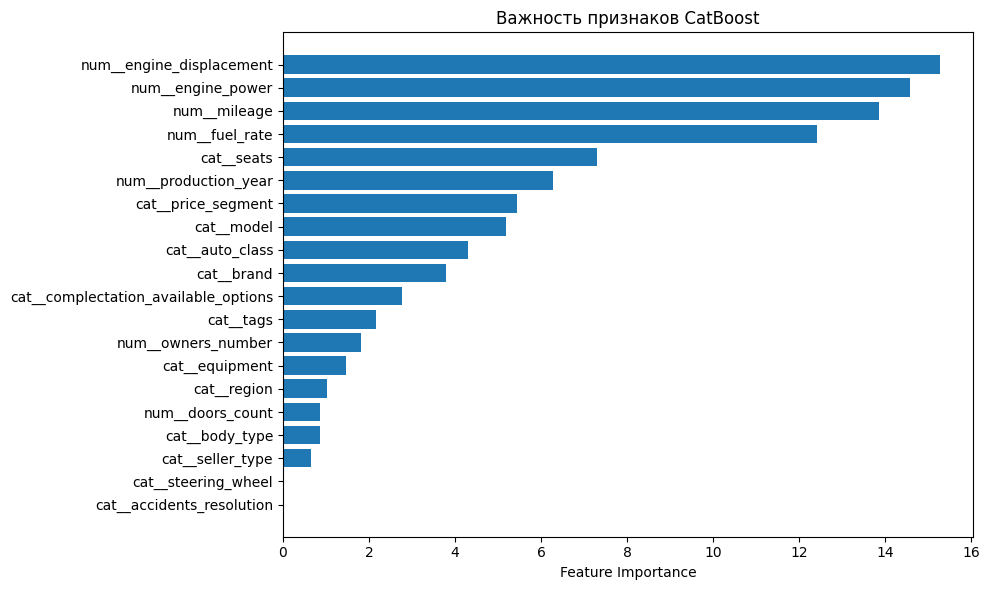

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top['feature'], top['importance'])
plt.xlabel('Feature Importance')
plt.title('Важность признаков CatBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()